In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Step 1: Load CIFAR-10 dataset with transformations
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)

train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

In [ ]:
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
val_dataset = CIFAR10(root='./data', train=False, download=True, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:12<00:00, 13.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Step 2: Define the modified LeNet model
class LeNetModified(nn.Module):
    def __init__(self):
        super(LeNetModified, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)  # 1st Convolution layer
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # 2nd Convolution layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 1st Fully Connected layer
        self.fc2 = nn.Linear(120, 84)  # 2nd Fully Connected layer
        self.fc3 = nn.Linear(84, 10)  # Output layer
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x= nn.functional.max_pool2d(x, 2)
        x = self.activation(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
model = LeNetModified().to(device)

In [ ]:
# Step 3: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Step 4: Train the model
num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(running_loss / total)  # Average loss over the epoch
    train_accuracies.append(correct / total)  # Train accuracy

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_losses.append(val_loss / total)  # Average validation loss
    val_accuracies.append(correct / total)  # Validation accuracy

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%")


Epoch 1/50, Train Loss: 1.7774, Val Loss: 1.4916, Train Acc: 0.34%, Val Acc: 0.45%
Epoch 2/50, Train Loss: 1.5424, Val Loss: 1.4244, Train Acc: 0.44%, Val Acc: 0.49%
Epoch 3/50, Train Loss: 1.4484, Val Loss: 1.3238, Train Acc: 0.48%, Val Acc: 0.52%
Epoch 4/50, Train Loss: 1.3886, Val Loss: 1.2514, Train Acc: 0.50%, Val Acc: 0.55%
Epoch 5/50, Train Loss: 1.3501, Val Loss: 1.2190, Train Acc: 0.51%, Val Acc: 0.56%
Epoch 6/50, Train Loss: 1.3152, Val Loss: 1.1904, Train Acc: 0.53%, Val Acc: 0.57%
Epoch 7/50, Train Loss: 1.2830, Val Loss: 1.1676, Train Acc: 0.54%, Val Acc: 0.59%
Epoch 8/50, Train Loss: 1.2608, Val Loss: 1.1411, Train Acc: 0.55%, Val Acc: 0.59%
Epoch 9/50, Train Loss: 1.2396, Val Loss: 1.1361, Train Acc: 0.56%, Val Acc: 0.59%
Epoch 10/50, Train Loss: 1.2151, Val Loss: 1.1047, Train Acc: 0.56%, Val Acc: 0.61%
Epoch 11/50, Train Loss: 1.1997, Val Loss: 1.1253, Train Acc: 0.57%, Val Acc: 0.60%
Epoch 12/50, Train Loss: 1.1859, Val Loss: 1.0776, Train Acc: 0.58%, Val Acc: 0.62%
E

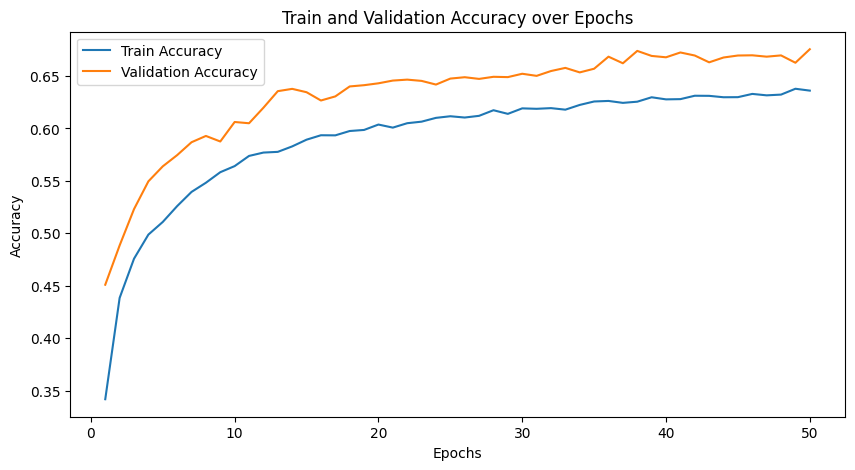

In [ ]:
# Step 5: Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy over Epochs')
plt.show()

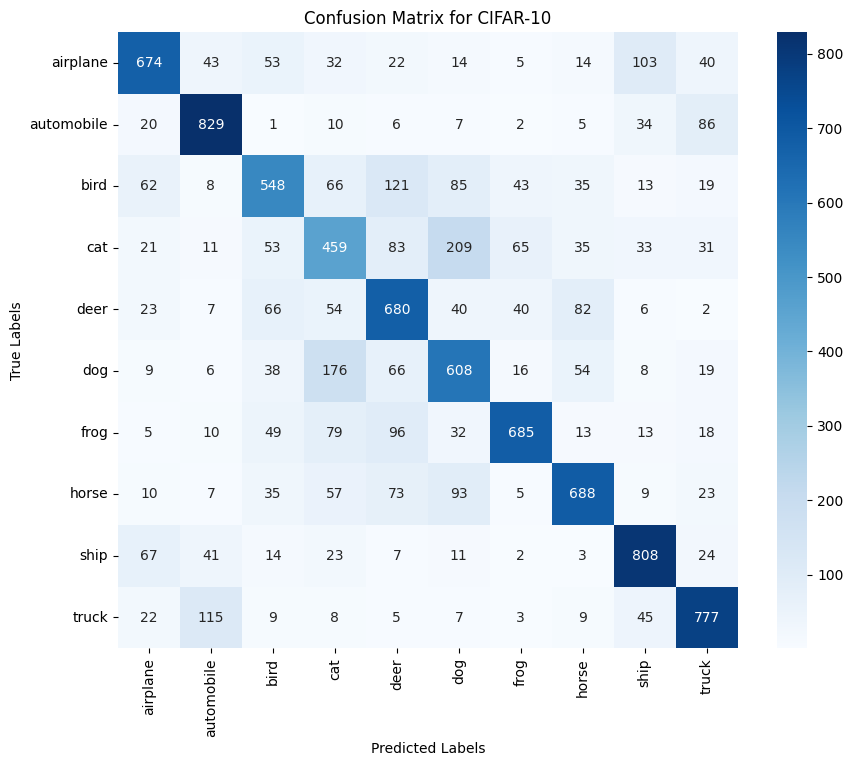

In [ ]:
# Step 6: Confusion Matrix
all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute and display the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CIFAR-10')
plt.show()
